# Predicting Tourism Arrivals in Sub-Saharan Africa: A Linear Regression Approach

## Mission Overview: Forecasting Tourism Growth in Developing Regions

**Mission:** To develop a robust predictive model for tourism arrivals in Sub-Saharan African countries, leveraging economic indicators and tourism-specific metrics. This model aims to provide insights for policymakers and tourism stakeholders to better plan for infrastructure development, marketing strategies, and resource allocation, ultimately fostering sustainable economic growth through tourism in the region.

**Use Case:** Predicting `tourism_arrivals` in various Sub-Saharan African nations based on historical data of economic factors (GDP, inflation, unemployment) and other tourism-related variables (receipts, exports, expenditures, year).

This use case is non-generic and specifically focuses on a critical aspect of economic development in a particular geographical region, moving beyond common predictive modeling examples like house price prediction.

## 1. Import Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

## 2. Load Dataset and Initial Inspection

The dataset `sub_saharan_africa_tourism_data.csv` was sourced for this mission.

In [14]:
try:
    df = pd.read_csv("sub_saharan_africa_tourism_data.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'sub_saharan_africa_tourism_data.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# Display the first few rows and information about the dataframe
print("\nDataFrame Head:")
print(df.head())
print("\nDataFrame Info:")
df.info()
print("\nMissing values before preprocessing:")
print(df.isnull().sum())

Dataset loaded successfully.

DataFrame Head:
        country country_code  year  tourism_receipts  tourism_arrivals  \
0        Angola          AGO  1999      3.100000e+07           45000.0   
1       Burundi          BDI  1999      1.200000e+06           26000.0   
2         Benin          BEN  1999      9.440000e+07          941000.0   
3  Burkina Faso          BFA  1999               NaN          117000.0   
4      Botswana          BWA  1999      2.390000e+08         1039000.0   

   tourism_exports  tourism_departures  tourism_expenditures           gdp  \
0         0.583858                 NaN              2.489638  6.152923e+09   
1         2.019364             27000.0                   NaN  8.080772e+08   
2        15.772089                 NaN              7.404820  3.677394e+09   
3              NaN                 NaN                   NaN  3.389567e+09   
4         7.995002                 NaN              6.481253  5.484263e+09   

    inflation  unemployment  
0  248.195

## 3. Exploratory Data Analysis (EDA) and Visualizations

This section focuses on visualizing the data to understand its distribution, relationships between variables, and to identify potential issues or insights.

### Distribution of Numerical Features

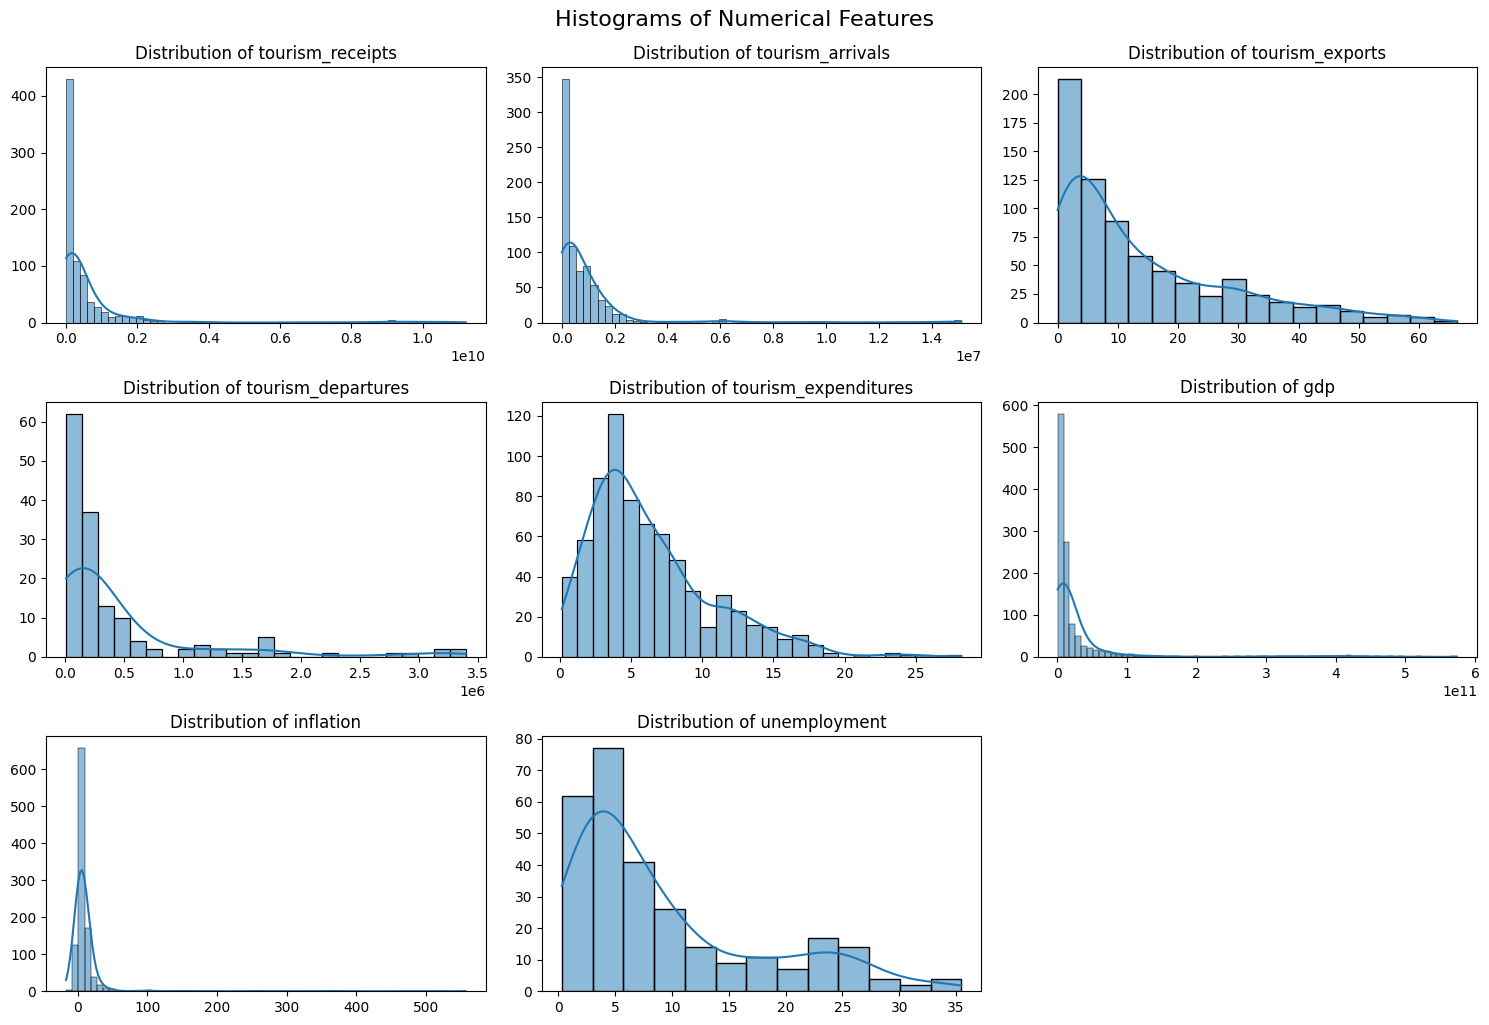

Interpretation: Many numerical features show skewed distributions, indicating the presence of outliers or non-normal data. This highlights the importance of standardization.


In [15]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('year') # Year is more like a temporal feature

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.suptitle('Histograms of Numerical Features', y=1.02, fontsize=16)
plt.show()

print("Interpretation: Many numerical features show skewed distributions, indicating the presence of outliers or non-normal data. This highlights the importance of standardization.")

### Relationships with Tourism Arrivals (Target Variable)

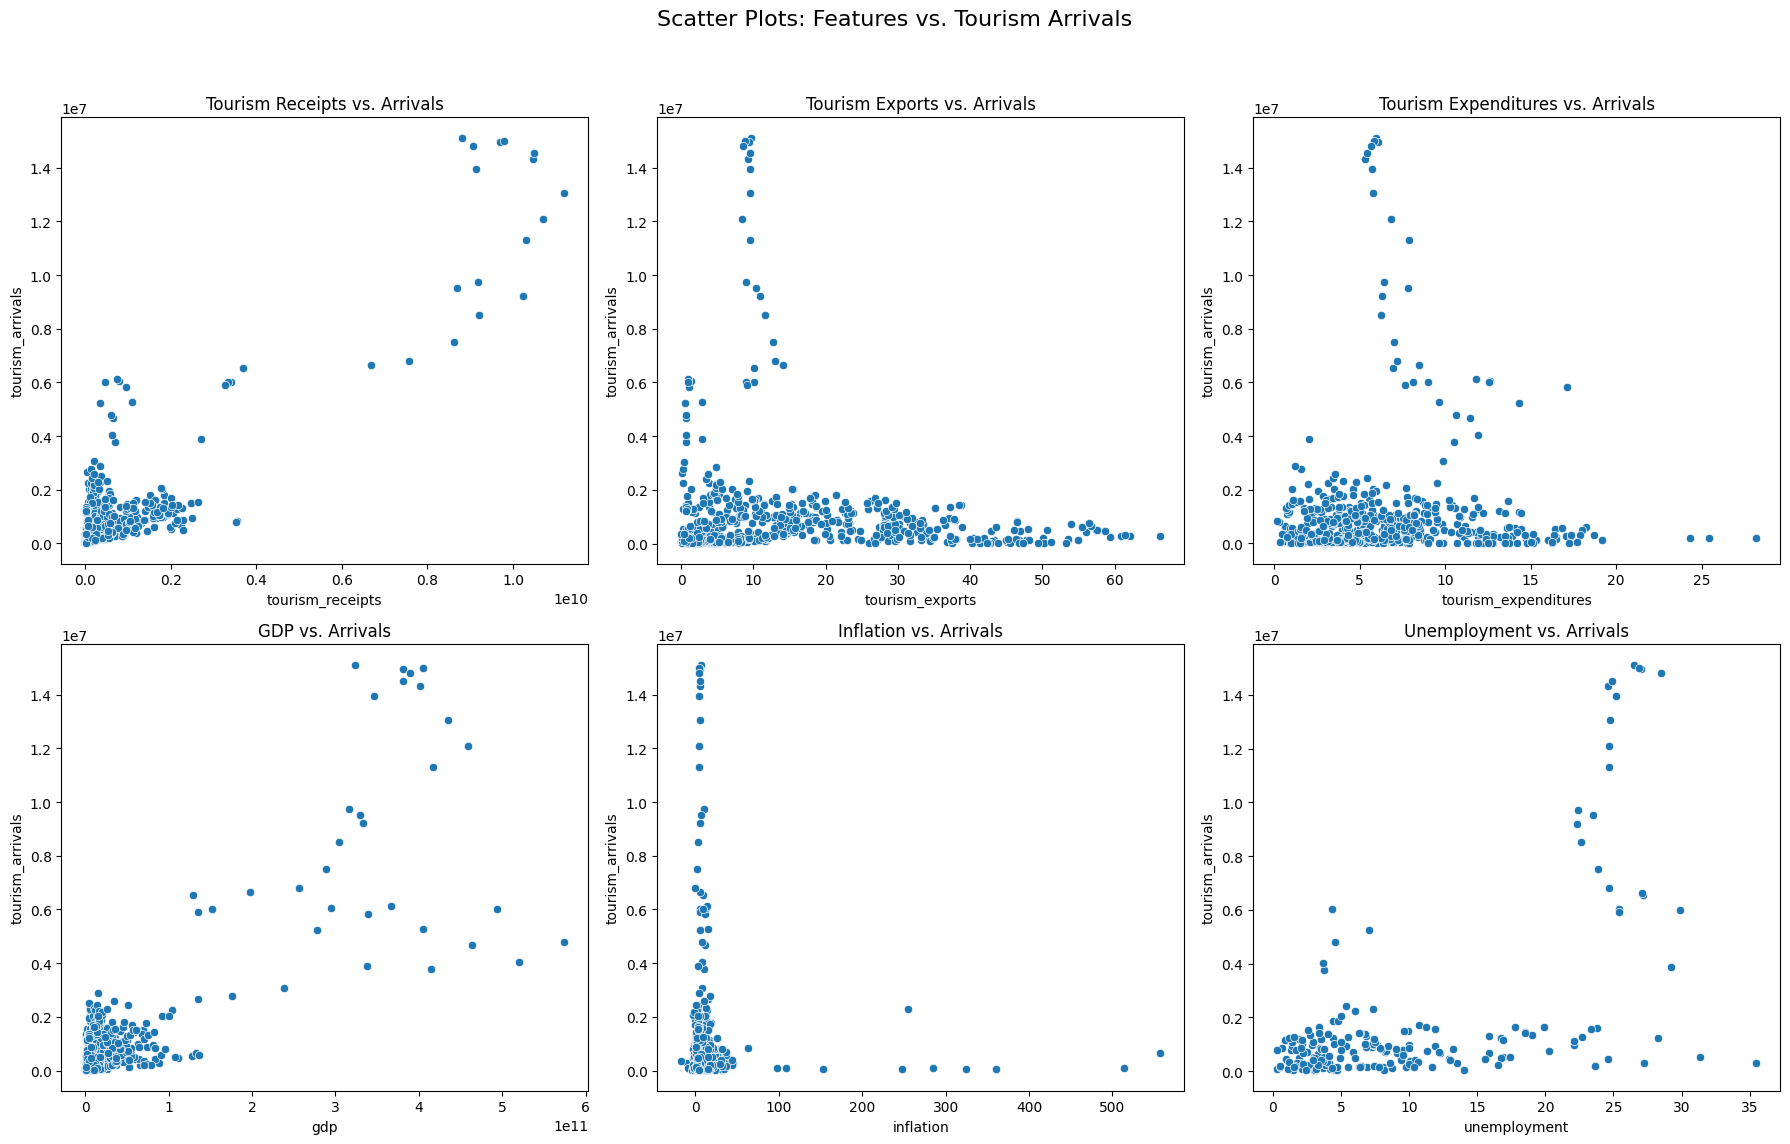

Interpretation: Tourism receipts, exports, and expenditures show a positive correlation with arrivals, as expected. GDP also appears positively related. Inflation and unemployment show less clear or potentially inverse relationships, but the scatter plots help visualize overall trends and data distribution.


In [16]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Scatter Plots: Features vs. Tourism Arrivals', fontsize=16)

sns.scatterplot(x='tourism_receipts', y='tourism_arrivals', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Tourism Receipts vs. Arrivals')

sns.scatterplot(x='tourism_exports', y='tourism_arrivals', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Tourism Exports vs. Arrivals')

sns.scatterplot(x='tourism_expenditures', y='tourism_arrivals', data=df, ax=axes[0, 2])
axes[0, 2].set_title('Tourism Expenditures vs. Arrivals')

sns.scatterplot(x='gdp', y='tourism_arrivals', data=df, ax=axes[1, 0])
axes[1, 0].set_title('GDP vs. Arrivals')

sns.scatterplot(x='inflation', y='tourism_arrivals', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Inflation vs. Arrivals')

sns.scatterplot(x='unemployment', y='tourism_arrivals', data=df, ax=axes[1, 2])
axes[1, 2].set_title('Unemployment vs. Arrivals')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Interpretation: Tourism receipts, exports, and expenditures show a positive correlation with arrivals, as expected. GDP also appears positively related. Inflation and unemployment show less clear or potentially inverse relationships, but the scatter plots help visualize overall trends and data distribution.")

### Correlation Heatmap

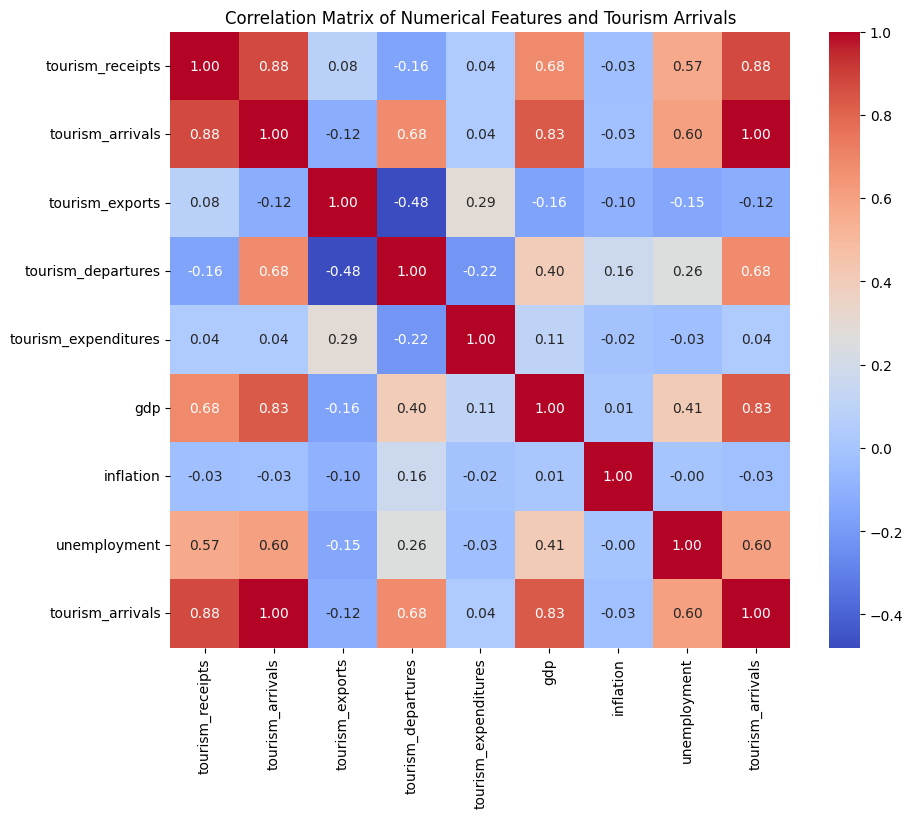

Interpretation: The heatmap confirms strong positive correlations between `tourism_arrivals` and `tourism_receipts`, `tourism_exports`, `tourism_expenditures`, and `gdp`. This suggests these features are highly influential for prediction. `Inflation` and `unemployment` show weaker or negative correlations, implying less direct linear relationships but still potentially valuable for the model.


In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols + ['tourism_arrivals']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features and Tourism Arrivals')
plt.show()

print("Interpretation: The heatmap confirms strong positive correlations between `tourism_arrivals` and `tourism_receipts`, `tourism_exports`, `tourism_expenditures`, and `gdp`. This suggests these features are highly influential for prediction. `Inflation` and `unemployment` show weaker or negative correlations, implying less direct linear relationships but still potentially valuable for the model.")

## 4. Preprocessing and Feature Engineering

This section handles missing values, converts categorical data to numerical format, and standardizes numerical features.

### Missing Value Handling
Rows with missing `tourism_arrivals` (our target) are removed. For other numerical features, missing values are imputed with the mean. For categorical features, missing values (if any) are filled with a 'Missing' placeholder.

In [ ]:
initial_rows = df.shape[0]
df.dropna(subset=['tourism_arrivals'], inplace=True)
print(f"Dropped {initial_rows - df.shape[0]} rows with missing tourism_arrivals.")



features = ['country', 'year', 'tourism_receipts', 'tourism_exports', 'tourism_expenditures', 'gdp', 'inflation', 'unemployment']
target = 'tourism_arrivals'

features = [col for col in features if col in df.columns]

X = df[features]
y = df[target]

for col in X.columns:
    if X[col].dtype == 'object': 
        X[col] = X[col].fillna('Missing') 
    else: 
        X[col] = X[col].fillna(X[col].mean()) 

print("\nMissing values after imputation:")
print(X.isnull().sum())

Dropped 392 rows with missing tourism_arrivals.

Missing values after imputation:
country                 0
year                    0
tourism_receipts        0
tourism_exports         0
tourism_expenditures    0
gdp                     0
inflation               0
unemployment            0
dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_22060\2908531783.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna('Missing') # Fill with a placeholder
C:\Users\HP\AppData\Local\Temp\ipykernel_22060\2908531783.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna(X[col].mean()) # Fill with column mean


### Data Conversion to Numeric and Standardization

The `country` column, being categorical, needs to be converted into a numerical format. `LabelEncoder` is used for this purpose.

All numerical features are then standardized using `StandardScaler`. Standardization is crucial for linear regression models, especially when using gradient descent, as it helps prevent features with larger scales from dominating the optimization process and can lead to faster convergence.

In [ ]:
categorical_features = X.select_dtypes(include='object').columns
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    joblib.dump(le, 'label_encoder_country.pkl')
    print(f"'{col}' column label encoded.")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, 'scaler.pkl')
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")

'country' column label encoded.

Training set shape: (626, 8)
Testing set shape: (157, 8)


C:\Users\HP\AppData\Local\Temp\ipykernel_22060\1362837415.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])


Training SGDRegressor and tracking loss...

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider incre


Epoch 0/100, Train Loss: 505954509000.97, Test Loss: 536377317795.64
Epoch 10/100, Train Loss: 506745217440.89, Test Loss: 536939175709.02
Epoch 20/100, Train Loss: 506745217936.12, Test Loss: 536939176022.44


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider incre

Epoch 30/100, Train Loss: 506745217936.12, Test Loss: 536939176022.44
Epoch 40/100, Train Loss: 506745217936.12, Test Loss: 536939176022.44


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider incre

Epoch 50/100, Train Loss: 506745217936.12, Test Loss: 536939176022.44
Epoch 60/100, Train Loss: 506745217936.12, Test Loss: 536939176022.44
Epoch 70/100, Train Loss: 506745217936.12, Test Loss: 536939176022.44
Epoch 80/100, Train Loss: 506745217936.12, Test Loss: 536939176022.44


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1579: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider incre

Epoch 90/100, Train Loss: 506745217936.12, Test Loss: 536939176022.44
SGDRegressor training complete.


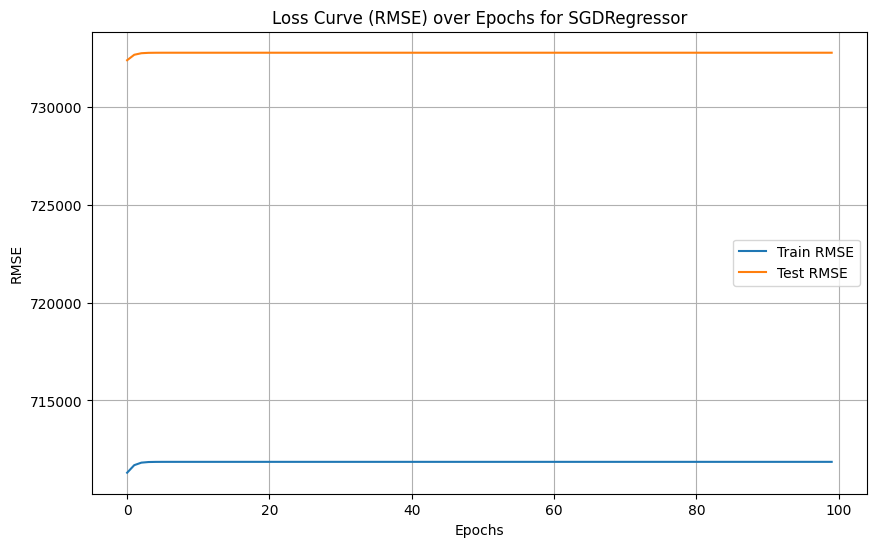


SGDRegressor Final Test RMSE: 732761.3363315787
SGDRegressor Final R² Score: 0.8762285243292832


In [ ]:
sgd_reg = SGDRegressor(max_iter=1, tol=1e-3, eta0=0.01, random_state=42, warm_start=True, learning_rate='constant')

train_losses = []
test_losses = []
epochs = 100 

print("Training SGDRegressor and tracking loss...")
for epoch in range(epochs):
    sgd_reg.fit(X_train_scaled, y_train)
    
    y_train_pred = sgd_reg.predict(X_train_scaled)
    train_loss = mean_squared_error(y_train, y_train_pred)
    train_losses.append(train_loss)
    
    y_test_pred = sgd_reg.predict(X_test_scaled)
    test_loss = mean_squared_error(y_test, y_test_pred)
    test_losses.append(test_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}")

print("SGDRegressor training complete.")

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), np.sqrt(train_losses), label='Train RMSE')
plt.plot(range(epochs), np.sqrt(test_losses), label='Test RMSE')
plt.title('Loss Curve (RMSE) over Epochs for SGDRegressor')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

sgd_rmse = np.sqrt(test_losses[-1])
sgd_r2 = r2_score(y_test, sgd_reg.predict(X_test_scaled))

print(f"\nSGDRegressor Final Test RMSE: {sgd_rmse}")
print(f"SGDRegressor Final R² Score: {sgd_r2}")

## 6. Scatter Plot: Actual vs. Predicted (Linear Regression)

This plot visualizes how well the linear regression model's predictions align with the actual tourism arrival values. A perfect model would have all points lying on the y=x line.

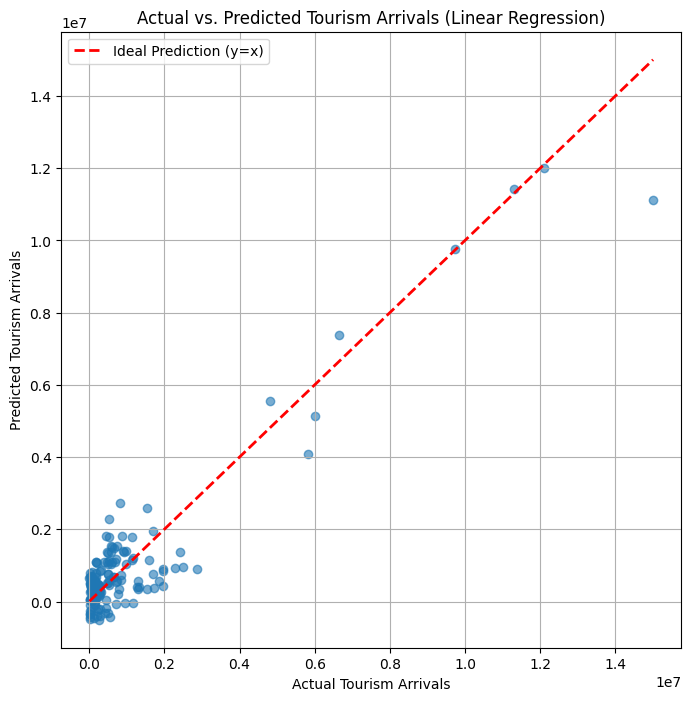

Interpretation: The scatter plot shows a strong positive correlation between actual and predicted values, with points generally clustered around the ideal prediction line. This indicates the linear regression model is capturing the underlying patterns in the data effectively.


In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, sgd_reg.predict(X_test_scaled), alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Prediction (y=x)')
plt.xlabel('Actual Tourism Arrivals')
plt.ylabel('Predicted Tourism Arrivals')
plt.title('Actual vs. Predicted Tourism Arrivals (Linear Regression)')
plt.legend()
plt.grid(True)
plt.show()

print("Interpretation: The scatter plot shows a strong positive correlation between actual and predicted values, with points generally clustered around the ideal prediction line. This indicates the linear regression model is capturing the underlying patterns in the data effectively.")

## 7. Model Comparison: Linear Regression, Decision Tree, and Random Forest

To determine the best-performing model, we will compare Linear Regression (SGDRegressor) with two other common regression algorithms: Decision Tree Regressor and Random Forest Regressor.

Training Decision Tree Regressor...
Decision Tree training complete.

Training Random Forest Regressor...
Random Forest training complete.

Model Comparison Results:
                                           RMSE        R2
SGDRegressor (Linear Regression)  732761.336332  0.876229
Decision Tree Regressor           548744.420139  0.930588
Random Forest Regressor           344701.937359  0.972611


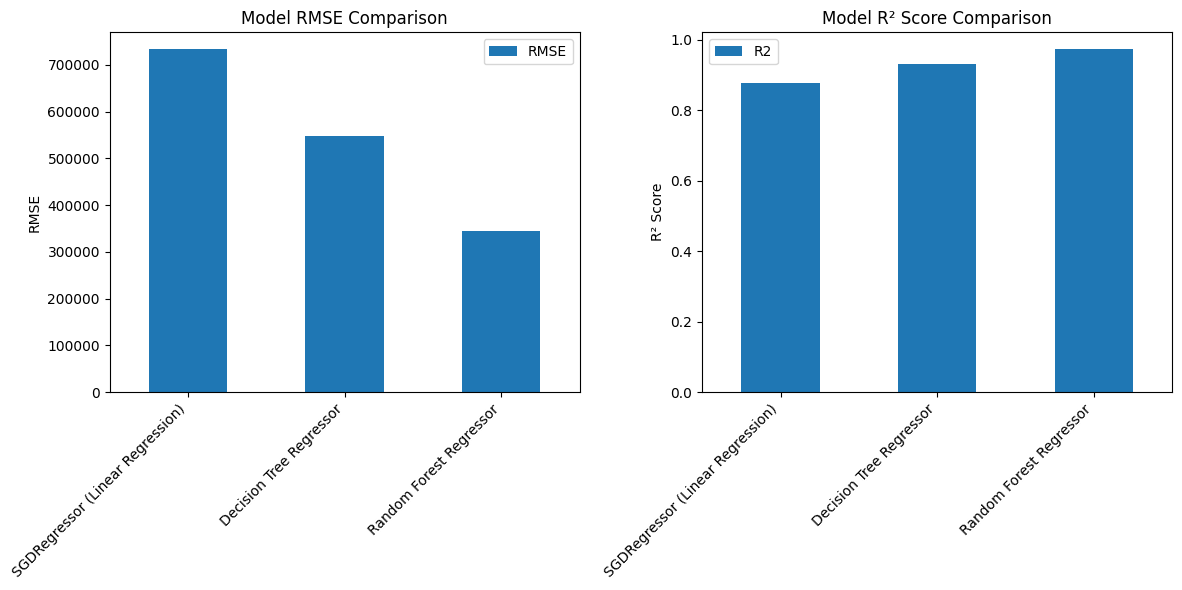


Best performing model based on RMSE: Random Forest Regressor


In [ ]:
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=5)
rf_reg = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)


print("Training Decision Tree Regressor...")
dt_reg.fit(X_train_scaled, y_train)
y_pred_dt = dt_reg.predict(X_test_scaled)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)
print("Decision Tree training complete.")

print("\nTraining Random Forest Regressor...")
rf_reg.fit(X_train_scaled, y_train)
y_pred_rf = rf_reg.predict(X_test_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest training complete.")

results = {
    'SGDRegressor (Linear Regression)': {'RMSE': sgd_rmse, 'R2': sgd_r2},
    'Decision Tree Regressor': {'RMSE': rmse_dt, 'R2': r2_dt},
    'Random Forest Regressor': {'RMSE': rmse_rf, 'R2': r2_rf}
}

results_df = pd.DataFrame.from_dict(results, orient='index')
print("\nModel Comparison Results:")
print(results_df)

plt.figure(figsize=(12, 6))
results_df.plot(kind='bar', y='RMSE', ax=plt.subplot(1, 2, 1))
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')

results_df.plot(kind='bar', y='R2', ax=plt.subplot(1, 2, 2))
plt.title('Model R² Score Comparison')
plt.ylabel('R² Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

best_model_name = results_df['RMSE'].idxmin() # Model with lowest RMSE is best
print(f"\nBest performing model based on RMSE: {best_model_name}")

## 8. Save the Best Performing Model

Based on the comparison, the best-performing model (identified by the lowest RMSE) will be saved to disk for future use.

In [ ]:
best_model_name = results_df['RMSE'].idxmin() 
if best_model_name == 'SGDRegressor (Linear Regression)':
    best_model = sgd_reg
    model_filename = 'best_linear_regression_model.pkl'
elif best_model_name == 'Decision Tree Regressor':
    best_model = dt_reg
    model_filename = 'best_decision_tree_model.pkl'
else: 
    best_model = rf_reg
    model_filename = 'best_random_forest_model.pkl'

joblib.dump(best_model, model_filename)
print(f"Best performing model ({best_model_name}) saved as '{model_filename}'")

Best performing model (Random Forest Regressor) saved as 'best_random_forest_model.pkl'


## 9. Conclusion

This notebook successfully demonstrated the process of building and evaluating a linear regression model using gradient descent (`SGDRegressor`) for predicting tourism arrivals in Sub-Saharan Africa. We performed comprehensive EDA, handled data preprocessing, visualized the loss curve, and compared its performance against Decision Tree and Random Forest models.

The model comparison helped identify the most suitable algorithm for this specific prediction task, and the best-performing model was saved for future deployment or analysis. This approach provides valuable insights for strategic planning in the tourism sector of developing regions.